# Running a multilevel sweep parameter study with PhysiCOOL


In [1]:
%matplotlib notebook
from typing import List
from pathlib import Path

import numpy as np

from physicool.config import ConfigFileParser
from physicool.optimization import PhysiCellBlackBox
from physicool.processing import Cells

def params_updater(new_values: List[float]) -> None:
    """
    Updates the cell speed and the migration bias.

    Parameters
    ----------
    new_values: list[float]
        The parameter values for (1) the cell speed,
        and (2) the migration bias.
    """
    cell_definition_name = "cancer"

    # Read the data from the file
    xml_parser = ConfigFileParser()
    cell_data = xml_parser.read_cell_data(cell_definition_name)

    # Update values
    cell_data.motility.speed = new_values[0]
    cell_data.motility.bias = new_values[1]
    xml_parser.update_params(cell_definition_name, cell_data)

def output_processor(output_path: Path) -> np.ndarray:
    cells = Cells(time=12, storage_path=output_path)
    coordinates = cells.get_cell_positions()
    
    return np.array([coord[1] for coord in coordinates])

my_model = PhysiCellBlackBox(params_updater, output_processor)

## Generating data (optional)
We do not have any data, so we need to generate some datasets. This step could be replaced by loading some target data from a file, though. However, it is important to make sure that the data fits the model output format!

In [2]:
params = [3.0, 0.8]
target_data = my_model.run(params)
print(target_data)

[ 493.04206599  493.040359    493.0342035   493.03374935  493.03467946
  493.04132742  493.04068911  493.03620114  493.02168721  493.04432921
  493.02873354  433.36577351  493.03798889  493.04370426  493.02532842
  493.02425516  117.46912305  493.0380357   493.03719015  493.02388827
  493.03533542 -493.02599261 -312.08146204 -493.04112537 -493.04323682
 -493.03648371 -493.02797488 -493.03838788 -493.04253248 -316.1162692
 -493.02116949 -493.03126568 -493.02269    -493.04019126 -493.02693731
 -493.02858736 -224.33077861 -493.02721958 -493.03277507 -493.03432779
 -493.03651109 -493.0313518   493.0301092   270.92497439  493.03611125
  493.02371592  493.03644856  493.03757291  493.04189234  493.02150625
  493.04205688  493.03973901  493.03259606  394.06046218  493.04042609
  493.02827902  493.0425897   493.02325499  493.02871831  493.03470668
  493.02554601  493.0220198   493.0273866   493.04095499  493.03928818
  493.02385564  493.04436145  349.62141265  493.02274252  493.03111355
  493.0

## Running the multilevel sweep pipeline

### The calibration model
First of all, **we need to define our "black-box"**. PhysiCOOL can help us do this, using `OptModel`.

`OptModel` will create a black-box function that **takes in a parameters dictionary**, **runs a PhysiCell simulation** with the updated parameter values and then **computes the metric you select** when initializing the model

You can **call this function independently**, and it will output an array with the values for the metric you choose. Here, we will be using it **inside our multilevel parameter sweep**.

<IPython.core.display.Javascript object>


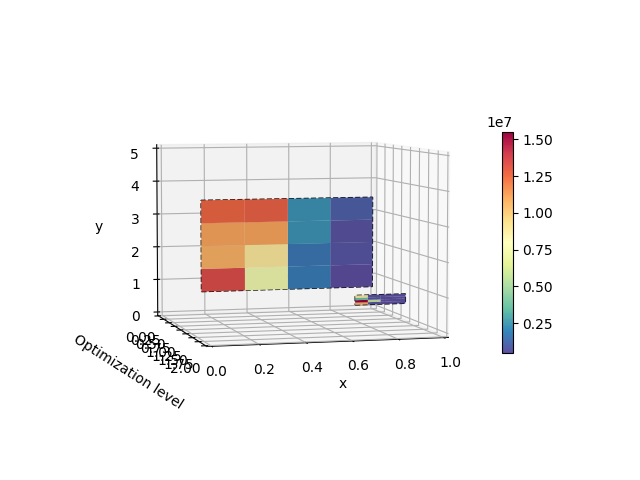

Optimal value found: 0.53; 0.8833333333333333


In [3]:
from physicool.optimization import MultiSweep

# Create our multisweep pipeline
number_of_levels = 2
points_per_direction = 5
percent_per_direction = 0.7

ms = MultiSweep(my_model, target_data, n_levels=number_of_levels, 
                npdir=points_per_direction, ppdir=percent_per_direction)

# Select initial value for the parameter sweep
ms.set_fit_value(2.0, 0.6)
ms.set_param_bounds((0, None), (0, 1))

# Run multisweep and get optimal parameters
x, y = ms.run_sweep()

print(f'Optimal value found: {x}; {y}')

In [5]:
ms.results[0]

array([[13588874.06018772,  8754845.43403183,  1623837.82393454,
          475797.02122521,   465914.65234935],
       [10741654.72987697,  9972657.51347235,  1730728.35407942,
          584522.51006477,   467109.96246415],
       [13133332.64849604,  7689711.41457127,  2329042.49637551,
          705980.6776773 ,   467894.9499033 ],
       [12287340.21223431, 12148245.15250804,  2121919.88365789,
          928525.91900246,   472368.88481205],
       [11488019.4441702 , 12489153.87901251,  3679642.21694473,
         1134688.23611817,   469170.93245393]])